In [1]:
%pylab inline
import radvel

import corner
import copy

from scipy import optimize
rc('savefig',dpi=120)

# Convenient function for plotting fits
def plot_results(like):
    fig = gcf()
    errorbar(
        like.x, like.model(t)+like.residuals(), 
        yerr=like.yerr, fmt='o'
        )
    plot(ti, like.model(ti))
    xlabel('Time')
    ylabel('RV')
    draw()

Populating the interactive namespace from numpy and matplotlib


Intialize Keplerian model parameters
====================================

In [2]:
params = radvel.Parameters(1,basis='per tc secosw sesinw k')
params['k1'] = radvel.Parameter(value=1)
params['per1'] = radvel.Parameter(value=1)
params['secosw1'] = radvel.Parameter(value=0.1)
params['sesinw1'] = radvel.Parameter(value=+0.2)
params['tc1'] = radvel.Parameter(value=0.)
rv_mod = radvel.RVModel(params)

Generate Synthetic Data
=======================

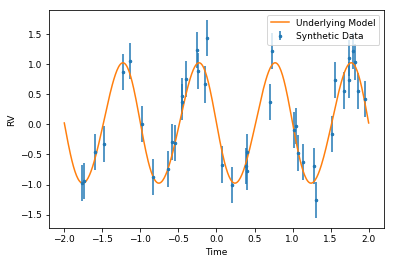

In [3]:
t = np.random.random_sample(40)
t = t * 4 - 2
t = np.sort(t)
ti = np.linspace(-2,2,400)
errvel = 0.3
syn_rv = rv_mod(t) + randn(t.size)*errvel
errorbar(t,syn_rv,yerr=errvel,fmt='.',label='Synthetic Data')
plot(ti,rv_mod(ti),label='Underlying Model')
xlabel('Time')
ylabel('RV')
legend()

Generate a likelihood
=====================

In [4]:
like_syn = radvel.likelihood.RVLikelihood(rv_mod,t,syn_rv,zeros(t.size)+errvel)
like_syn.params['gamma'] = radvel.Parameter(value=0)
like_syn.params['jit'] = radvel.Parameter(value=errvel)

truths = copy.deepcopy(like_syn.params) # Store away model parameters for later reference
like_syn.params.update(dict(k1=radvel.Parameter(value=3),
                            secosw1=radvel.Parameter(value=0.1),
                            sesinw1=radvel.Parameter(value=0.1),
                            tc1=radvel.Parameter(value=0.1))) # perturb the starting guess

like_syn.params['jit'].vary = False # Don't vary jitter


Perform a maximum likelihood fit
===============================

 final_simplex: (array([[ 0.99931359,  0.00899453,  0.04993041,  0.29554198,  1.00954508,
        -0.00285937, -0.00114447,  0.00153916],
       [ 0.99932077,  0.00898312,  0.04993981,  0.2956322 ,  1.00953447,
        -0.00286552, -0.0011603 ,  0.00153845],
       [ 0.99932056,  0.0089776 ,  0.0500143 ,  0.29544576,  1.00949925,
        -0.00285972, -0.00115646,  0.00153772],
       [ 0.99932913,  0.00898137,  0.04995496,  0.2955065 ,  1.00945524,
        -0.00285861, -0.00114617,  0.00153876],
       [ 0.99931109,  0.00898919,  0.04997264,  0.29551537,  1.00947152,
        -0.00286114, -0.0011541 ,  0.00153839],
       [ 0.99932352,  0.00898354,  0.05001112,  0.29556738,  1.00949256,
        -0.00286739, -0.00117434,  0.0015371 ],
       [ 0.99931854,  0.00900148,  0.04987957,  0.29554519,  1.00951135,
        -0.0028555 , -0.00112829,  0.0015403 ],
       [ 0.99932127,  0.00897349,  0.0499384 ,  0.29558749,  1.00945817,
        -0.00286228, -0.00115237,  0.00153881],
       [ 0.9993

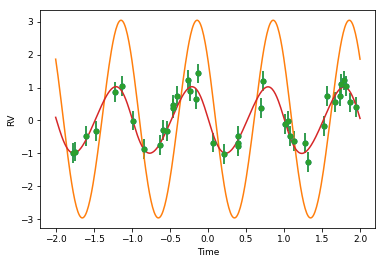

In [5]:
plot_results(like_syn) # Plot initial model
res  = optimize.minimize(like_syn.neglogprob_array, like_syn.get_vary_params(), method='Nelder-Mead' )
#res  = optimize.minimize(like_syn.neglogprob_array, like_syn.get_vary_params(), method='L-BFGS-B' )
print(res)
print(like_syn)
plot_results(like_syn) # plot best fit model

Instantiate a posterior object
===============================

In [6]:
post = radvel.posterior.Posterior(like_syn)
post.params.update(dict(per1=radvel.Parameter(value=1),
                        k1=radvel.Parameter(value=1)))
post.params['jit'].vary = True
post.priors += [radvel.prior.EccentricityPrior( 1 )]
post.priors += [radvel.prior.Gaussian( 'jit', errvel, 0.1)]
post.priors += [radvel.prior.Gaussian( 'per1', 1, 0.1)]
post.priors += [radvel.prior.Gaussian( 'tc1', 0, 0.1)]

print(post.priors)
print(post)

[e1 constrained to be < 0.99, Gaussian prior on jit, mu=0.3, sigma=0.1, Gaussian prior on per1, mu=1, sigma=0.1, Gaussian prior on tc1, mu=0, sigma=0.1]
parameter                     value      vary
per1                              1       True
tc1                      0.00898312       True
secosw1                   0.0499398       True
sesinw1                    0.295632       True
k1                                1       True
dvdt                    -0.00286552       True
curv                     -0.0011603       True
jit                             0.3       True
gamma                    0.00153845       True

Priors
------
e1 constrained to be < 0.99
Gaussian prior on jit, mu=0.3, sigma=0.1
Gaussian prior on per1, mu=1, sigma=0.1
Gaussian prior on tc1, mu=0, sigma=0.1



Perform maximum likelihood fit on posterior
=========================================

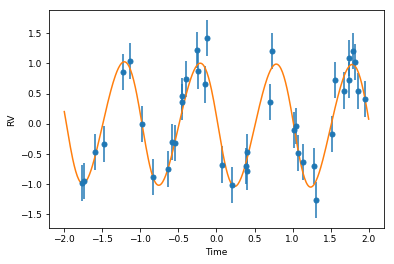

In [7]:
res  = optimize.minimize(post.neglogprob_array, post.get_vary_params(), method='Nelder-Mead' )
plot_results(post.likelihood)

Use mcmc to sample the posterior distribution
========================

1. use `emcee` package to run MCMC
1. corner plot visualizes parameters and correlations
1. Blue lines show the synthetic model parameters

In [8]:
df = radvel.mcmc(post,nwalkers=20,nrun=1000)

8000/160000 (5.0%) steps complete; Running 9305.43 steps/s; Mean acceptance rate = 48.8%; Min Tz = 2084.1; Max G-R = 1.01      
Discarding burn-in now that the chains are marginally well-mixed

88000/160000 (55.0%) steps complete; Running 10753.25 steps/s; Mean acceptance rate = 41.9%; Min Tz = 4046.0; Max G-R = 1.01      
Chains are well-mixed after 88000 steps! MCMC completed in 8.6 seconds




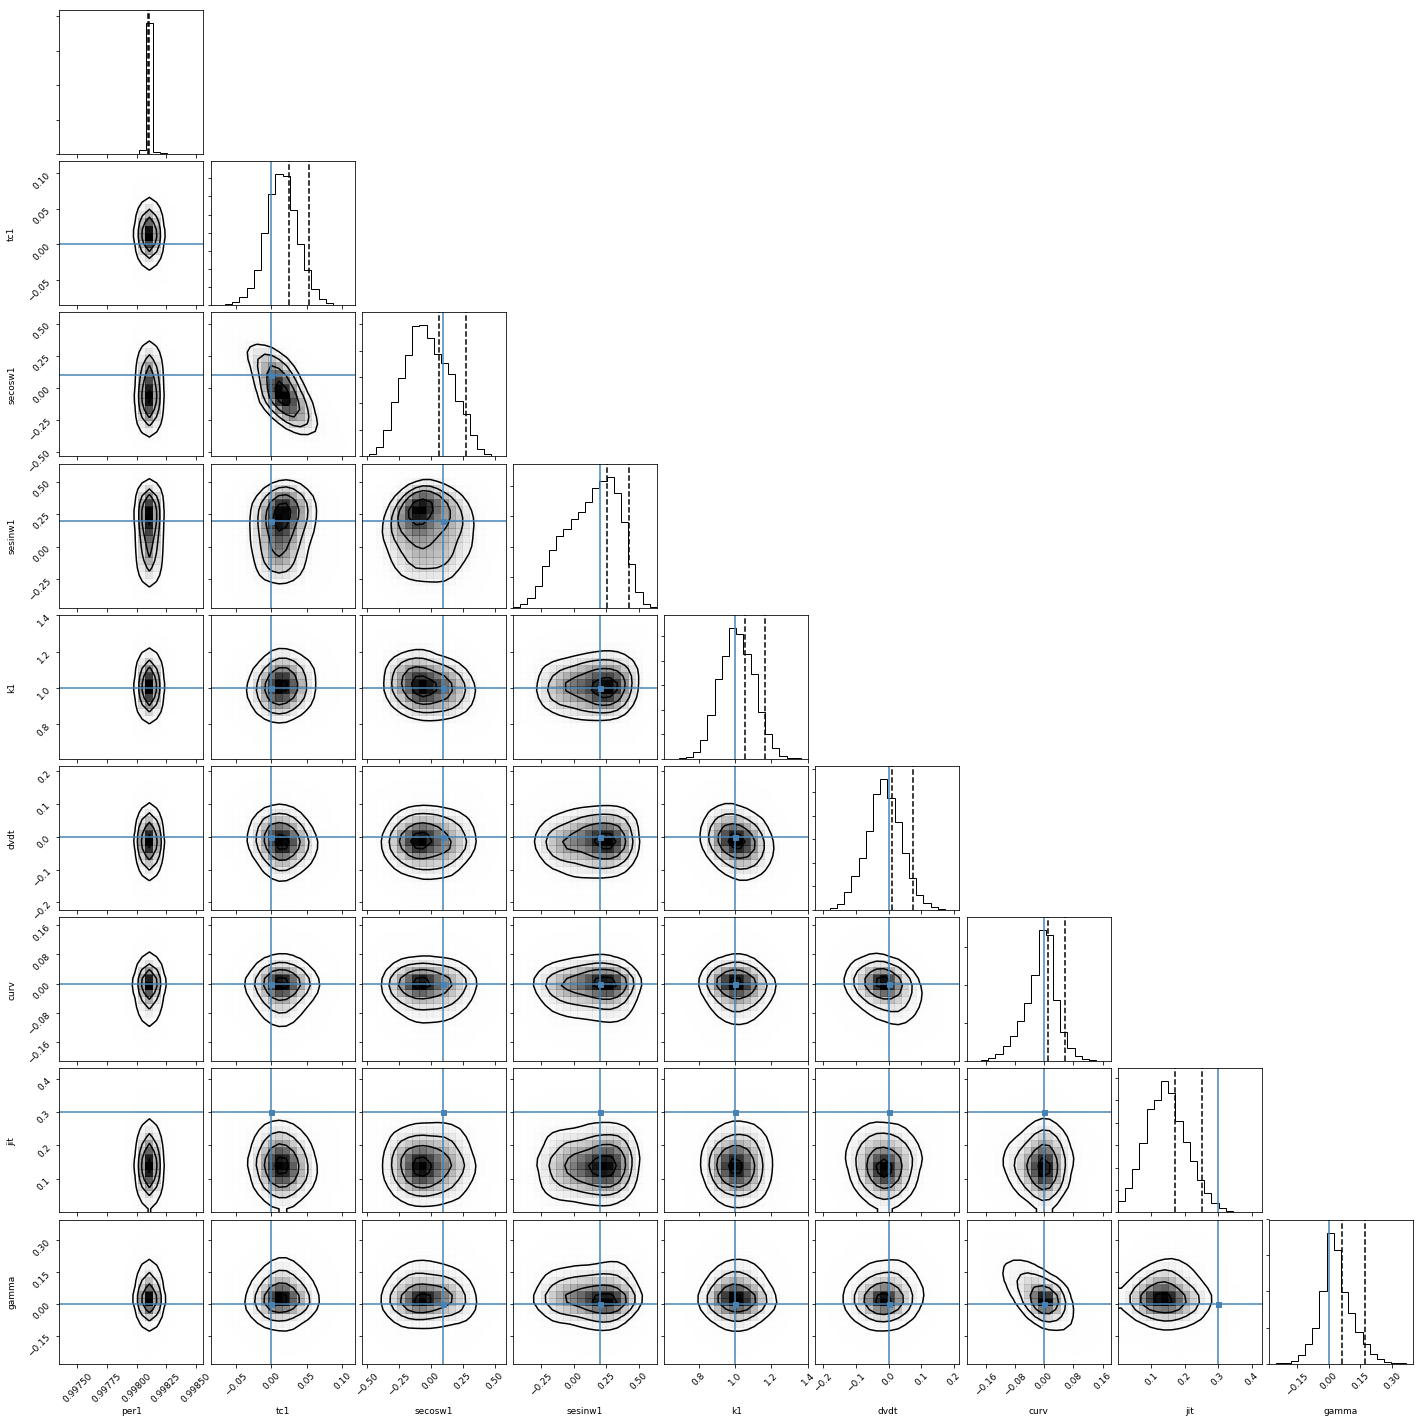

In [9]:
labels = [k for k in post.params.keys() if post.params[k].vary]



fig = corner.corner(
    df[labels],
    labels=labels,
    truths=[truths[k].value for k in labels ],
    quantiles=[0.68,0.95],
    plot_datapoints=False,
    smooth=True,
    bins=20
    )

(array([    32.,     89.,    195.,    628.,   2076.,   5972.,  13750.,
         23607.,  26197.,   7454.]),
 array([-21.2108565 , -19.47680777, -17.74275904, -16.0087103 ,
        -14.27466157, -12.54061284, -10.80656411,  -9.07251537,
         -7.33846664,  -5.60441791,  -3.87036918]),
 <a list of 10 Patch objects>)

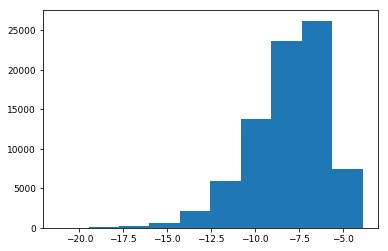

In [10]:
hist(df.lnprobability)